# CSJ 2024 — Constituency Summary
This notebook loads the Canada Summer Jobs data, filters to **2024 only**, and summarizes **total jobs created** and **total amount paid** per constituency.

## Cell 1 — Load & Filter to 2024
Read the raw CSV with latin-1 encoding. Keep only 2024 rows and the columns we need: **Constituency**, **Amount Paid**, and **Jobs Created**.

In [ ]:
import pandas as pd
import numpy as np

# Load raw CSV
df = pd.read_csv('csj-results-master.csv', encoding='latin-1', dtype=str)
df.columns = ['Program Year','Region','Activity Constituency','Constituency','Employer','Amount Paid','Jobs Created']

# Filter to 2024 only
df = df[df['Program Year'].str.strip() == '2024'].copy()

# Keep only the columns we need
df = df[['Constituency', 'Amount Paid', 'Jobs Created']]

# Clean text
df['Constituency'] = df['Constituency'].str.replace('\n', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip()

# Convert to numeric
df['Amount Paid'] = pd.to_numeric(df['Amount Paid'].str.strip(), errors='coerce').fillna(0).astype(int)
df['Jobs Created'] = pd.to_numeric(df['Jobs Created'].str.strip(), errors='coerce').fillna(0).astype(int)

print(f'2024 records loaded: {len(df):,} rows')
print(f'Unique constituencies: {df["Constituency"].nunique()}')
df.head()

## Cell 2 — Aggregate by Constituency
Group by **Constituency** and sum the total **Amount Paid** and **Jobs Created**. Calculate **Cost Per Job** for each constituency.

In [ ]:
# Group by constituency
summary = df.groupby('Constituency', as_index=False).agg(
    Total_Amount_Paid=('Amount Paid', 'sum'),
    Total_Jobs_Created=('Jobs Created', 'sum')
)

# Calculate cost per job
summary['Cost Per Job'] = np.where(
    summary['Total_Jobs_Created'] > 0,
    (summary['Total_Amount_Paid'] / summary['Total_Jobs_Created']).round(2),
    0.0
)

# Ensure numeric types
summary['Total_Amount_Paid'] = summary['Total_Amount_Paid'].astype(int)
summary['Total_Jobs_Created'] = summary['Total_Jobs_Created'].astype(int)
summary['Cost Per Job'] = summary['Cost Per Job'].astype(float)

# Sort by total amount paid descending
summary = summary.sort_values('Total_Amount_Paid', ascending=False).reset_index(drop=True)

print(f'Constituencies: {len(summary)}')
print(f'Total Amount Paid (all): ${summary["Total_Amount_Paid"].sum():,}')
print(f'Total Jobs Created (all): {summary["Total_Jobs_Created"].sum():,}')
summary.head(10)

## Cell 3 — Highest & Lowest Cost Per Job
Identify the **10 constituencies with the highest** and **10 with the lowest** cost per job created.
Visualise both extremes side-by-side in a horizontal bar chart.

=== TOP 10 — HIGHEST Cost Per Job ===
  Oakville-Nord - Burlington                    $  6,646.28  (162 jobs, $1,076,698 paid)
  St. Catharines                                $  6,061.05  (175 jobs, $1,060,684 paid)
  Surrey - Newton                               $  6,050.31  (143 jobs, $865,195 paid)
  Hamilton Mountain                             $  6,023.12  (172 jobs, $1,035,977 paid)
  Vancouver Kingsway                            $  5,941.96  (112 jobs, $665,500 paid)
  North Vancouver                               $  5,767.70  (115 jobs, $663,286 paid)
  Sherwood Park - Fort Saskatchewan             $  5,765.20  (203 jobs, $1,170,335 paid)
  Etobicoke-Centre                              $  5,657.03  (187 jobs, $1,057,865 paid)
  Kitchener-Centre                              $  5,644.27  (166 jobs, $936,949 paid)
  Elmwood - Transcona                           $  5,598.88  (139 jobs, $778,244 paid)

=== BOTTOM 10 — LOWEST Cost Per Job ===
  Renfrew - Nipissing - Pembroke         

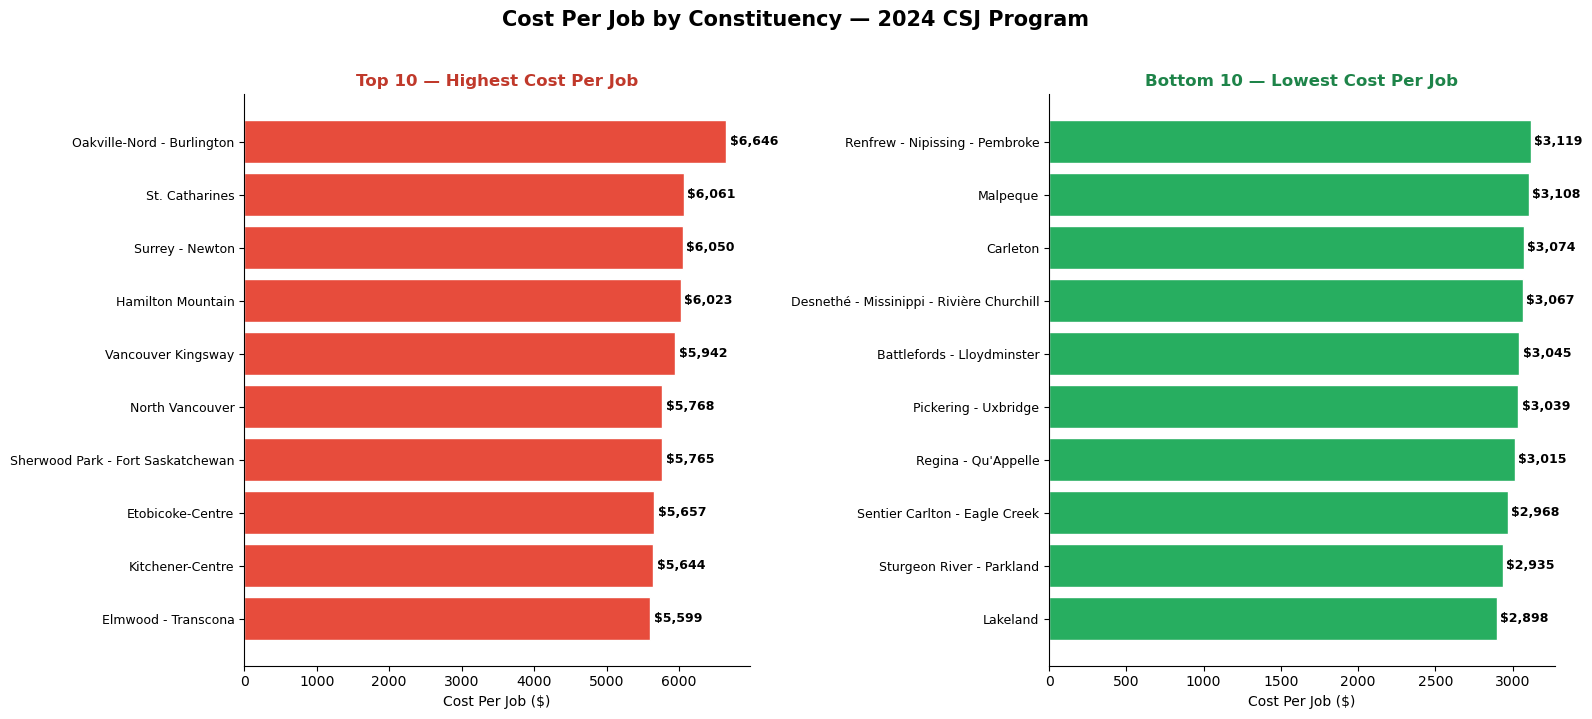


Chart saved to cost_per_job_analysis.png


In [13]:
import matplotlib.pyplot as plt

# Get top 10 highest and bottom 10 lowest cost per job
sorted_df = summary.copy()
sorted_df['Cost Per Job'] = pd.to_numeric(sorted_df['Cost Per Job'].astype(str).str.replace(',', ''), errors='coerce').fillna(0.0)
sorted_df['Total_Amount_Paid'] = pd.to_numeric(sorted_df['Total_Amount_Paid'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype(int)
sorted_df['Total_Jobs_Created'] = pd.to_numeric(sorted_df['Total_Jobs_Created'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype(int)
sorted_df = sorted_df.sort_values('Cost Per Job', ascending=False)
top_10 = sorted_df.head(10).copy()
bottom_10 = sorted_df.tail(10).copy()

# Print summaries
print('=== TOP 10 — HIGHEST Cost Per Job ===')
for _, row in top_10.iterrows():
    name = str(row['Constituency'])
    cpj = float(row['Cost Per Job'])
    jobs = int(row['Total_Jobs_Created'])
    paid = int(row['Total_Amount_Paid'])
    print(f'  {name:<45} ${cpj:>10,.2f}  ({jobs} jobs, ${paid:,} paid)')

print()
print('=== BOTTOM 10 — LOWEST Cost Per Job ===')
for _, row in bottom_10.iterrows():
    name = str(row['Constituency'])
    cpj = float(row['Cost Per Job'])
    jobs = int(row['Total_Jobs_Created'])
    paid = int(row['Total_Amount_Paid'])
    print(f'  {name:<45} ${cpj:>10,.2f}  ({jobs} jobs, ${paid:,} paid)')

# --- Horizontal bar chart: top 10 vs bottom 10 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Cost Per Job by Constituency — 2024 CSJ Program', fontsize=15, fontweight='bold', y=1.02)

# Top 10 (highest) — red tones
t10 = top_10.sort_values('Cost Per Job', ascending=True)
bars1 = ax1.barh(t10['Constituency'], t10['Cost Per Job'].astype(float), color='#e74c3c', edgecolor='white')
ax1.set_title('Top 10 — Highest Cost Per Job', fontsize=12, fontweight='bold', color='#c0392b')
ax1.set_xlabel('Cost Per Job ($)')
for bar in bars1:
    w = bar.get_width()
    ax1.text(w + 50, bar.get_y() + bar.get_height()/2, f'${w:,.0f}', va='center', fontsize=9, fontweight='bold')

# Bottom 10 (lowest) — green tones
b10 = bottom_10.sort_values('Cost Per Job', ascending=True)
bars2 = ax2.barh(b10['Constituency'], b10['Cost Per Job'].astype(float), color='#27ae60', edgecolor='white')
ax2.set_title('Bottom 10 — Lowest Cost Per Job', fontsize=12, fontweight='bold', color='#1e8449')
ax2.set_xlabel('Cost Per Job ($)')
for bar in bars2:
    w = bar.get_width()
    ax2.text(w + 20, bar.get_y() + bar.get_height()/2, f'${w:,.0f}', va='center', fontsize=9, fontweight='bold')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.savefig('cost_per_job_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nChart saved to cost_per_job_analysis.png')

## Cell 4 — Format Numbers with Comma Separators
Apply comma formatting to all numeric columns for readability (e.g. `14258` → `14,258`).

In [ ]:
# Format numbers with commas
summary['Total_Amount_Paid'] = summary['Total_Amount_Paid'].apply(lambda x: f'{int(x):,}')
summary['Total_Jobs_Created'] = summary['Total_Jobs_Created'].apply(lambda x: f'{int(x):,}')
summary['Cost Per Job'] = summary['Cost Per Job'].apply(lambda x: f'{float(x):,.2f}')

print('Formatting applied ✓')
summary.head(10)

## Cell 5 — Save Cleaned File
Export the constituency summary to `csj-results-cleaned.csv` (UTF-8).

In [ ]:
import os

output_file = 'csj-results-cleaned.csv'
summary.to_csv(output_file, index=False, encoding='utf-8')

size_kb = os.path.getsize(output_file) / 1024
print(f'Saved: {output_file}')
print(f'File size: {size_kb:.1f} KB')
print(f'Rows: {len(summary):,} constituencies')
print(f'Columns: {list(summary.columns)}')
print()
summary